<a href="https://colab.research.google.com/github/Adityxax/Video-Short-Boundary-Detection/blob/main/Marine_Predator_Algorithm.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

###Upload Video File


In [ ]:
from google.colab import files

print("Please upload your video file :")
uploaded = files.upload()
video_path = list(uploaded.keys())[0]

print(f"Uploaded video: {video_path}")

Please upload your video file :


Saving SP Video (30 sec).mp4 to SP Video (30 sec) (1).mp4
Uploaded video: SP Video (30 sec) (1).mp4


###Extract Frames from Video


In [ ]:
import cv2
import os

def extract_frames(video_path, output_folder="extracted_frames", frame_rate=1):
    if not os.path.exists(output_folder):
        os.makedirs(output_folder)

    cap = cv2.VideoCapture(video_path)
    fps = cap.get(cv2.CAP_PROP_FPS)
    print(f"Original video FPS: {fps:.2f}")

    if fps == 0:
        print("Error reading video FPS.")
        return []

    frame_interval = int(fps / frame_rate)
    count = 0
    saved_count = 0
    extracted_files = []

    while True:
        ret, frame = cap.read()
        if not ret:
            break

        if count % frame_interval == 0:
            filename = os.path.join(output_folder, f"frame_{saved_count:04d}.png")
            cv2.imwrite(filename, frame)
            extracted_files.append(filename)
            saved_count += 1

        count += 1

    cap.release()
    print(f"Extracted {saved_count} frames at {frame_rate} FPS to folder '{output_folder}'.")
    return extracted_files

# Example usage
extracted_frames = extract_frames(video_path, frame_rate=30)  # Change frame rate here

Original video FPS: 30.00
Extracted 926 frames at 30 FPS to folder 'extracted_frames'.


###Convert Frames to Grayscale


In [ ]:
import cv2
import os

def convert_to_grayscale(input_folder="extracted_frames", output_folder="grayscale_frames"):
    if not os.path.exists(input_folder):
        print(f"Input folder '{input_folder}' does not exist.")
        return []
    if not os.path.exists(output_folder):
        os.makedirs(output_folder)

    frame_files = sorted(os.listdir(input_folder))
    grayscale_files = []

    for file in frame_files:
        input_path = os.path.join(input_folder, file)
        image = cv2.imread(input_path)
        gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
        output_path = os.path.join(output_folder, file)
        cv2.imwrite(output_path, gray)
        grayscale_files.append(output_path)

    print(f"Converted {len(grayscale_files)} frames to grayscale and saved to '{output_folder}'.")
    return grayscale_files

grayscale_frames = convert_to_grayscale(input_folder="extracted_frames", output_folder="grayscale_frames")

Converted 926 frames to grayscale and saved to 'grayscale_frames'.


###Feature Extraction from Grayscale Frames


Extracted features from 926 frames.
Frame file: grayscale_frames/frame_0000.png
Average intensity: 100.44


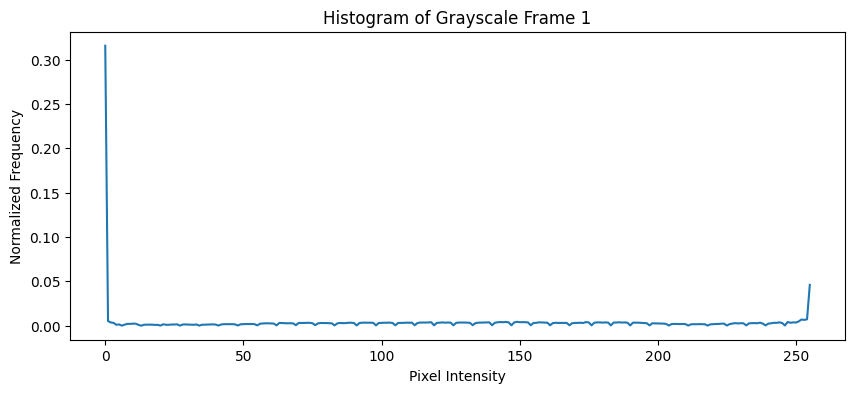

Frame file: grayscale_frames/frame_0001.png
Average intensity: 98.61


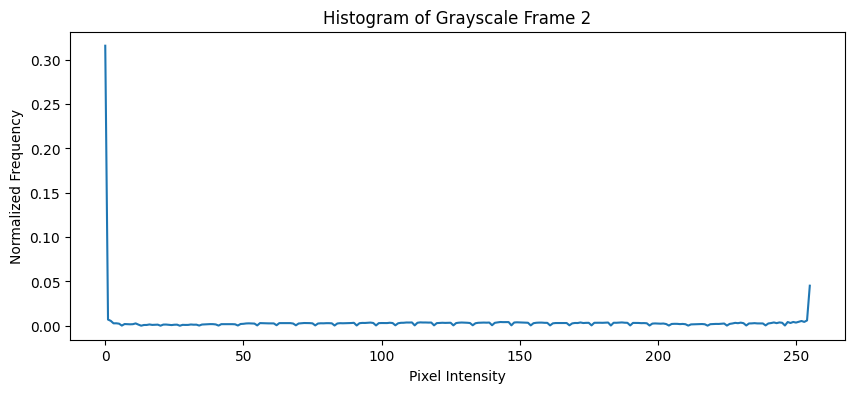

Frame file: grayscale_frames/frame_0002.png
Average intensity: 100.16


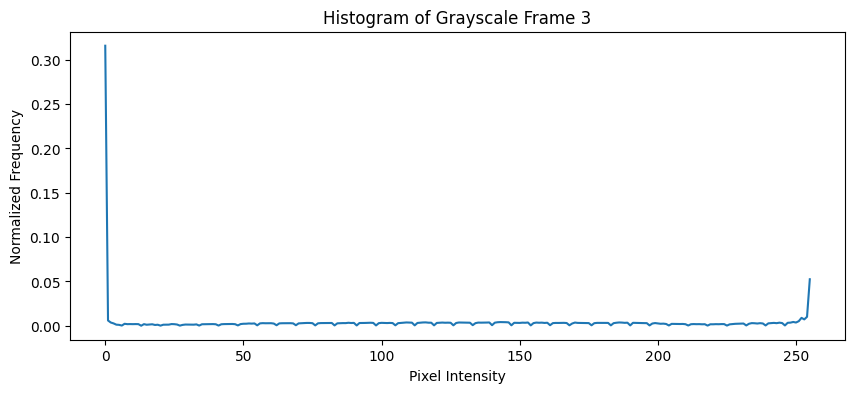

In [ ]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

def extract_frame_features(frame_files):
    """
    Extract features such as average intensity and normalized histogram from grayscale frames.
    Returns a list of dictionaries containing features per frame.
    """
    features = []

    for frame_path in frame_files:
        gray_img = cv2.imread(frame_path, cv2.IMREAD_GRAYSCALE)
        avg_intensity = np.mean(gray_img)
        hist = cv2.calcHist([gray_img], [0], None, [256], [0, 256])
        hist = hist.flatten() / np.sum(hist)  # Normalize histogram

        features.append({
            "frame_file": frame_path,
            "average_intensity": avg_intensity,
            "histogram": hist,
        })

    print(f"Extracted features from {len(features)} frames.")
    return features

# Example usage
features = extract_frame_features(grayscale_frames)

# Display features for first 3 frames
for i, feat in enumerate(features[:3]):
    print(f"Frame file: {feat['frame_file']}")
    print(f"Average intensity: {feat['average_intensity']:.2f}")
    plt.figure(figsize=(10,4))
    plt.plot(feat["histogram"])
    plt.title(f"Histogram of Grayscale Frame {i+1}")
    plt.xlabel("Pixel Intensity")
    plt.ylabel("Normalized Frequency")
    plt.show()

In [ ]:
!pip install opencv-python-headless tensorflow

In [ ]:
import os
import cv2
import numpy as np

input_folder = "grayscale_frames"
frame_files = sorted([os.path.join(input_folder, f) for f in os.listdir(input_folder) if f.endswith(".png") or f.endswith(".jpg")])

def convert_grayscale_to_rgb(frame_files, output_folder="grayscale_rgb_frames"):
    if not os.path.exists(output_folder):
        os.makedirs(output_folder)
    rgb_files = []
    for fpath in frame_files:
        gray = cv2.imread(fpath, cv2.IMREAD_GRAYSCALE)
        rgb_img = cv2.merge([gray, gray, gray])
        out_path = os.path.join(output_folder, os.path.basename(fpath))
        cv2.imwrite(out_path, rgb_img)
        rgb_files.append(out_path)
    print(f"Converted {len(rgb_files)} grayscale images to RGB format for CNN input.")
    return rgb_files

rgb_frame_files = convert_grayscale_to_rgb(frame_files)

Converted 926 grayscale images to RGB format for CNN input.


In [ ]:
import tensorflow as tf
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.applications.resnet50 import preprocess_input
from tensorflow.keras.preprocessing import image

model = ResNet50(weights='imagenet', include_top=False, pooling='avg')  # Outputs 2048-dim features

def extract_cnn_features_from_rgb_frames(frame_files, target_size=(224, 224)):
    features = []
    for fpath in frame_files:
        img = image.load_img(fpath, target_size=target_size)
        x = image.img_to_array(img)
        x = np.expand_dims(x, axis=0)
        x = preprocess_input(x)
        feat_vec = model.predict(x)
        features.append(feat_vec.flatten())
    features = np.array(features)
    print(f"Extracted CNN features from {len(features)} frames. Each vector size: {features.shape[1]}")
    return features

cnn_features = extract_cnn_features_from_rgb_frames(rgb_frame_files)

94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 215ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 225ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 210ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 215ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 243ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 228ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 256ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 342ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 571ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 363ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 374ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 349ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 220ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 208ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 215ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 235ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 210ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 221ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 220ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 218ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 237ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 225ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 206ms/step
1/1 ━━━━━━━━━━━━